In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score 
from  sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Data Understanding

In [256]:
df = pd.read_csv('housePrice.csv', encoding='ISO-8859-1')

In [257]:
df.head(5)

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


In [258]:
df = df.drop("Price(USD)", axis = 1)

In [259]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Area       3479 non-null   object 
 1   Room       3479 non-null   int64  
 2   Parking    3479 non-null   bool   
 3   Warehouse  3479 non-null   bool   
 4   Elevator   3479 non-null   bool   
 5   Address    3456 non-null   object 
 6   Price      3479 non-null   float64
dtypes: bool(3), float64(1), int64(1), object(2)
memory usage: 119.0+ KB


In [260]:
'''duplicates =df[df.duplicated(keep=False)]
duplicates
df = df.drop_duplicates().reset_index(drop=True)'''

'duplicates =df[df.duplicated(keep=False)]\nduplicates\ndf = df.drop_duplicates().reset_index(drop=True)'

In [261]:
df['Area'] = pd.to_numeric(df['Area'], errors='coerce')


In [262]:
df.isnull().sum()

Area          6
Room          0
Parking       0
Warehouse     0
Elevator      0
Address      23
Price         0
dtype: int64

The number of nulls is much less than 5% of the data, so it is best to delete those rows, as it has little negative impact on the model and the data becomes cleaner.

In [263]:
df = df.dropna()

In [264]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Area,3450.0,1.069174e+02,6.955098e+01,30.0,6.900000e+01,9.000000e+01,1.200000e+02,9.290000e+02
Room,3450.0,2.081159e+00,7.602161e-01,0.0,2.000000e+00,2.000000e+00,2.000000e+00,5.000000e+00
Price,3450.0,5.375563e+09,8.125918e+09,3600000.0,1.419250e+09,2.900000e+09,6.000000e+09,9.240000e+10


In [265]:
df['Address'].value_counts()

Address
Punak                     161
Pardis                    146
West Ferdows Boulevard    145
Gheitarieh                140
Shahran                   130
                         ... 
Chardangeh                  1
Mehrabad                    1
Pakdasht KhatunAbad         1
Kazemabad                   1
Yakhchiabad                 1
Name: count, Length: 192, dtype: int64

# Feature Engineering

In [266]:
df['Avg_Price_By_address'] = df.groupby('Address')['Price'].transform('mean')
df['Priceـperـsquareـmeter']=df['Price']/df['Area']
df.sample(8)

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Avg_Price_By_address,Priceـperـsquareـmeter
456,99.0,3,True,True,True,North Program Organization,4.190000e+09,7.417222e+09,4.232323e+07
650,157.0,3,True,True,True,Shahrake Gharb,1.850000e+10,1.196988e+10,1.178344e+08
1583,66.0,2,True,False,True,Ostad Moein,1.580000e+09,1.926878e+09,2.393939e+07
948,84.0,2,True,True,True,North Program Organization,3.250000e+09,7.417222e+09,3.869048e+07
3263,106.0,2,True,True,True,Farmanieh,4.450000e+09,2.091728e+10,4.198113e+07
984,150.0,2,False,True,True,Chardangeh,1.200000e+09,1.200000e+09,8.000000e+06
724,200.0,3,True,True,True,Niavaran,2.000000e+10,1.989321e+10,1.000000e+08
2081,153.0,3,True,True,True,Punak,7.500000e+09,3.728304e+09,4.901961e+07


In [267]:
'''cols = ['Area','Room','Price(USD)']

# آمار قبل از clip
print("آمار قبل از محدودسازی:")
print(df[cols].describe())

# اعمال clip
for col in cols:
    df[col] = df[col].clip(lower=Lower_bound[col], upper=Upper_bound[col])

# آمار بعد از clip
print("\nآمار بعد از محدودسازی:")
print(df[cols].describe())'''


'cols = [\'Area\',\'Room\',\'Price(USD)\']\n\n# آمار قبل از clip\nprint("آمار قبل از محدودسازی:")\nprint(df[cols].describe())\n\n# اعمال clip\nfor col in cols:\n    df[col] = df[col].clip(lower=Lower_bound[col], upper=Upper_bound[col])\n\n# آمار بعد از clip\nprint("\nآمار بعد از محدودسازی:")\nprint(df[cols].describe())'

In [268]:
'''cols = ['Area','Room','Price']

Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

Lower_bound = Q1 - 1.5 * IQR
Upper_bound = Q3 + 1.5 * IQR


for col in cols:
    df[col] = df[col].clip(lower=Lower_bound[col], upper=Upper_bound[col])'''


"cols = ['Area','Room','Price']\n\nQ1 = df[cols].quantile(0.25)\nQ3 = df[cols].quantile(0.75)\nIQR = Q3 - Q1\n\nLower_bound = Q1 - 1.5 * IQR\nUpper_bound = Q3 + 1.5 * IQR\n\n\nfor col in cols:\n    df[col] = df[col].clip(lower=Lower_bound[col], upper=Upper_bound[col])"

# Visualization

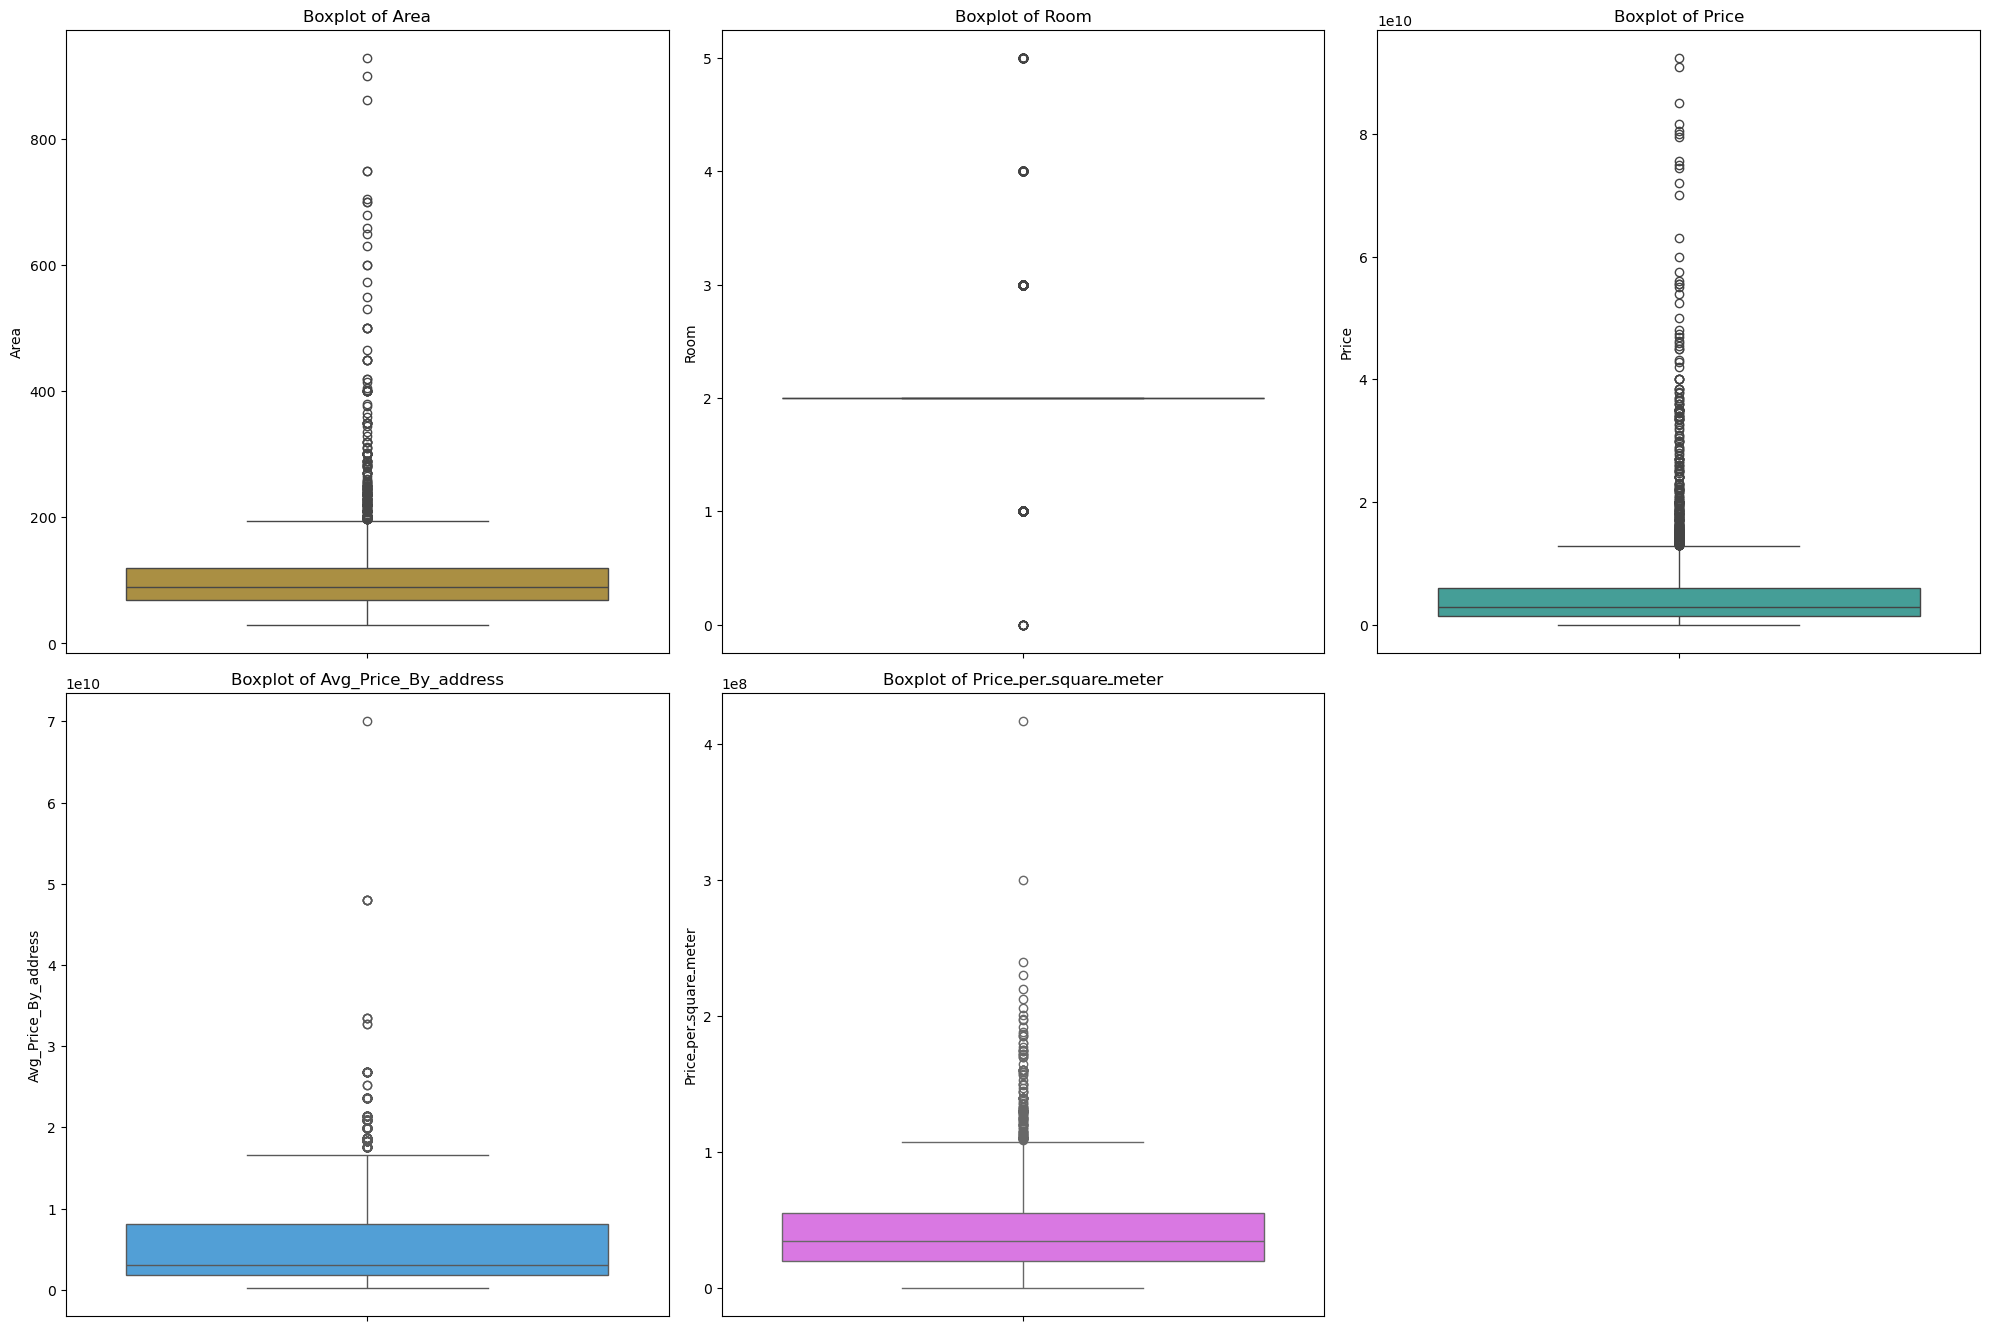

In [269]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Define color palette
palette = sns.color_palette("husl")

#to show Outliers in data 
plt.figure(figsize=(20, 20))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3,3, i)
    sns.boxplot(y=df[col], color=palette[i])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


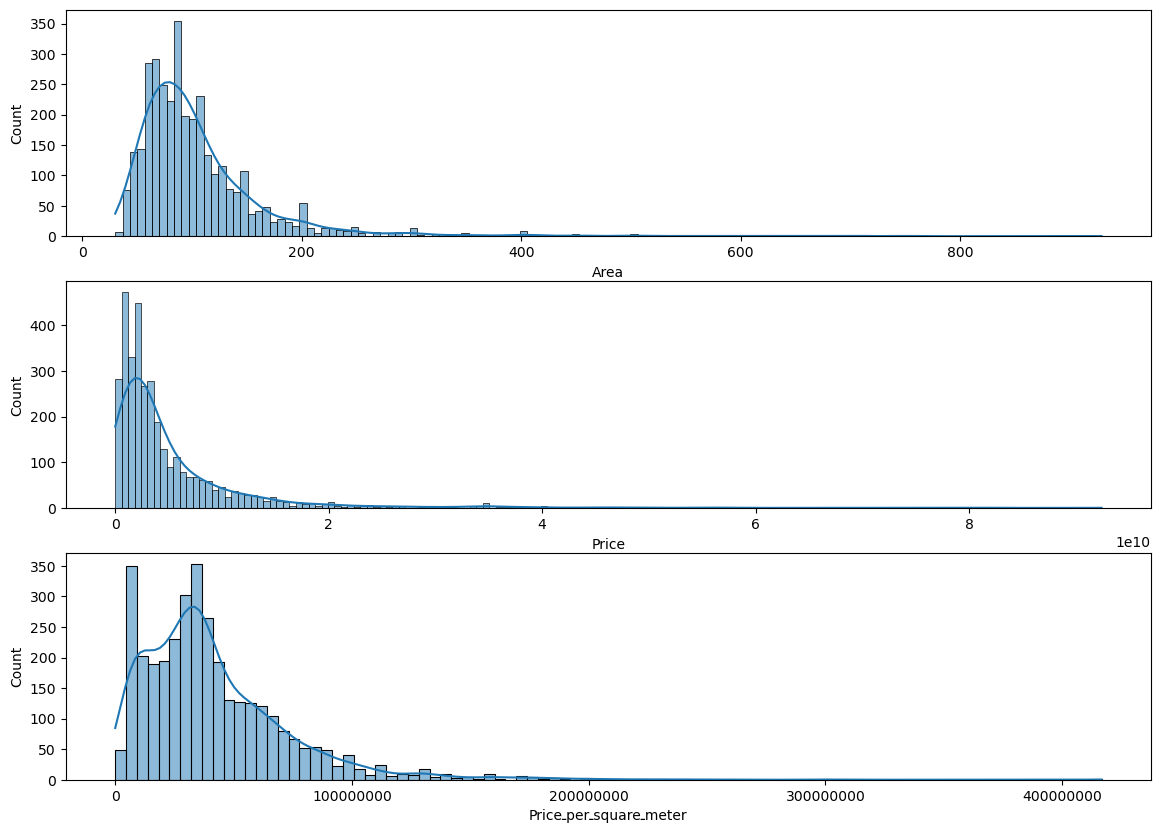

In [270]:
plt.figure(figsize = (14, 10))

plt.subplot(3, 1, 1)
sns.histplot(x = df['Area'], kde = True)

plt.subplot(3, 1, 2)
sns.histplot(x = df['Price'], kde = True)

plt.subplot(3, 1, 3)
sns.histplot(x = df['Priceـperـsquareـmeter'], kde = True)

plt.ticklabel_format(style='plain', axis='both') 
plt.show()


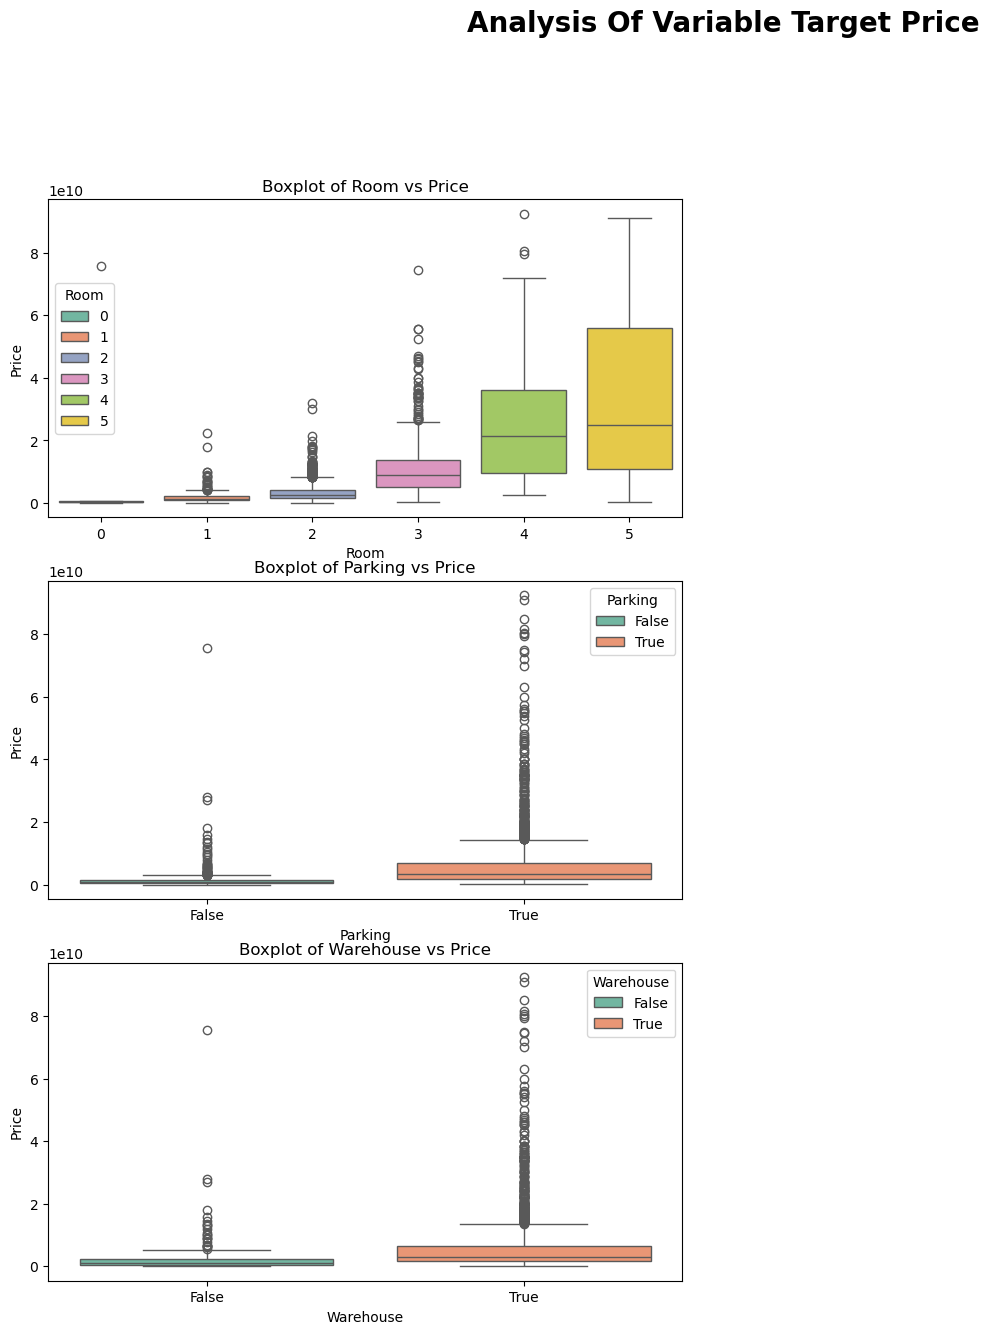

In [271]:
plt.figure(figsize=(18, 19))
plt.suptitle("Analysis Of Variable Target Price", fontweight="bold", fontsize=20)

axes=[]

axes.append(plt.subplot(4,2,1))
sns.boxplot(x='Room', y='Price', hue="Room", data=df, palette='Set2')
plt.title('Boxplot of Room vs Price')

'''axes.append(plt.subplot(4,2,2))
sns.violinplot(x='Room', y='Price', hue="Room", data=df, palette='Set2')
plt.title('violinplot of Room vs Price')'''

axes.append(plt.subplot(4,2,3))
sns.boxplot(x='Parking' , y='Price' ,hue='Parking' ,data=df ,palette='Set2')
plt.title('Boxplot of Parking vs Price')

'''axes.append(plt.subplot(4,2,4))
sns.violinplot(x='Parking', y='Price', hue="Parking", data=df, palette='Set2')
plt.title('violinplot of Parking vs Price')'''


axes.append(plt.subplot(4,2,5))
sns.boxplot(x='Warehouse' , y='Price' ,hue='Warehouse' ,data=df ,palette='Set2')
plt.title('Boxplot of Warehouse vs Price')

'''axes.append(plt.subplot(4,2,6))
sns.violinplot(x='Warehouse', y='Price', hue="Warehouse", data=df, palette='Set2')
plt.title('violinplot of Warehouse vs Price(')'''


plt.show()    

'axes.append(plt.subplot(2,1,2))\nsns.violinplot(x=\'Room\', y=\'Area\', hue="Room", data=df, palette=\'Set2\')\nplt.title(\'violinplot of Room vs Area\')\nplt.show()'

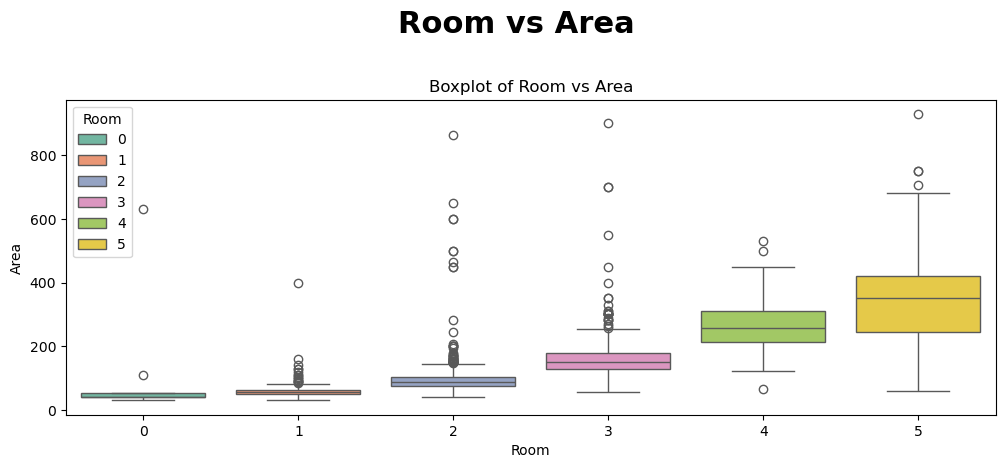

In [272]:
plt.figure(figsize=(12,9))
plt.suptitle("Room vs Area", fontweight="bold", fontsize=22)
axes=[]

axes.append(plt.subplot(2,1,1))
sns.boxplot(x='Room' , y='Area' ,hue='Room' ,data=df ,palette='Set2')
plt.title('Boxplot of Room vs Area')

'''axes.append(plt.subplot(2,1,2))
sns.violinplot(x='Room', y='Area', hue="Room", data=df, palette='Set2')
plt.title('violinplot of Room vs Area')
plt.show()'''

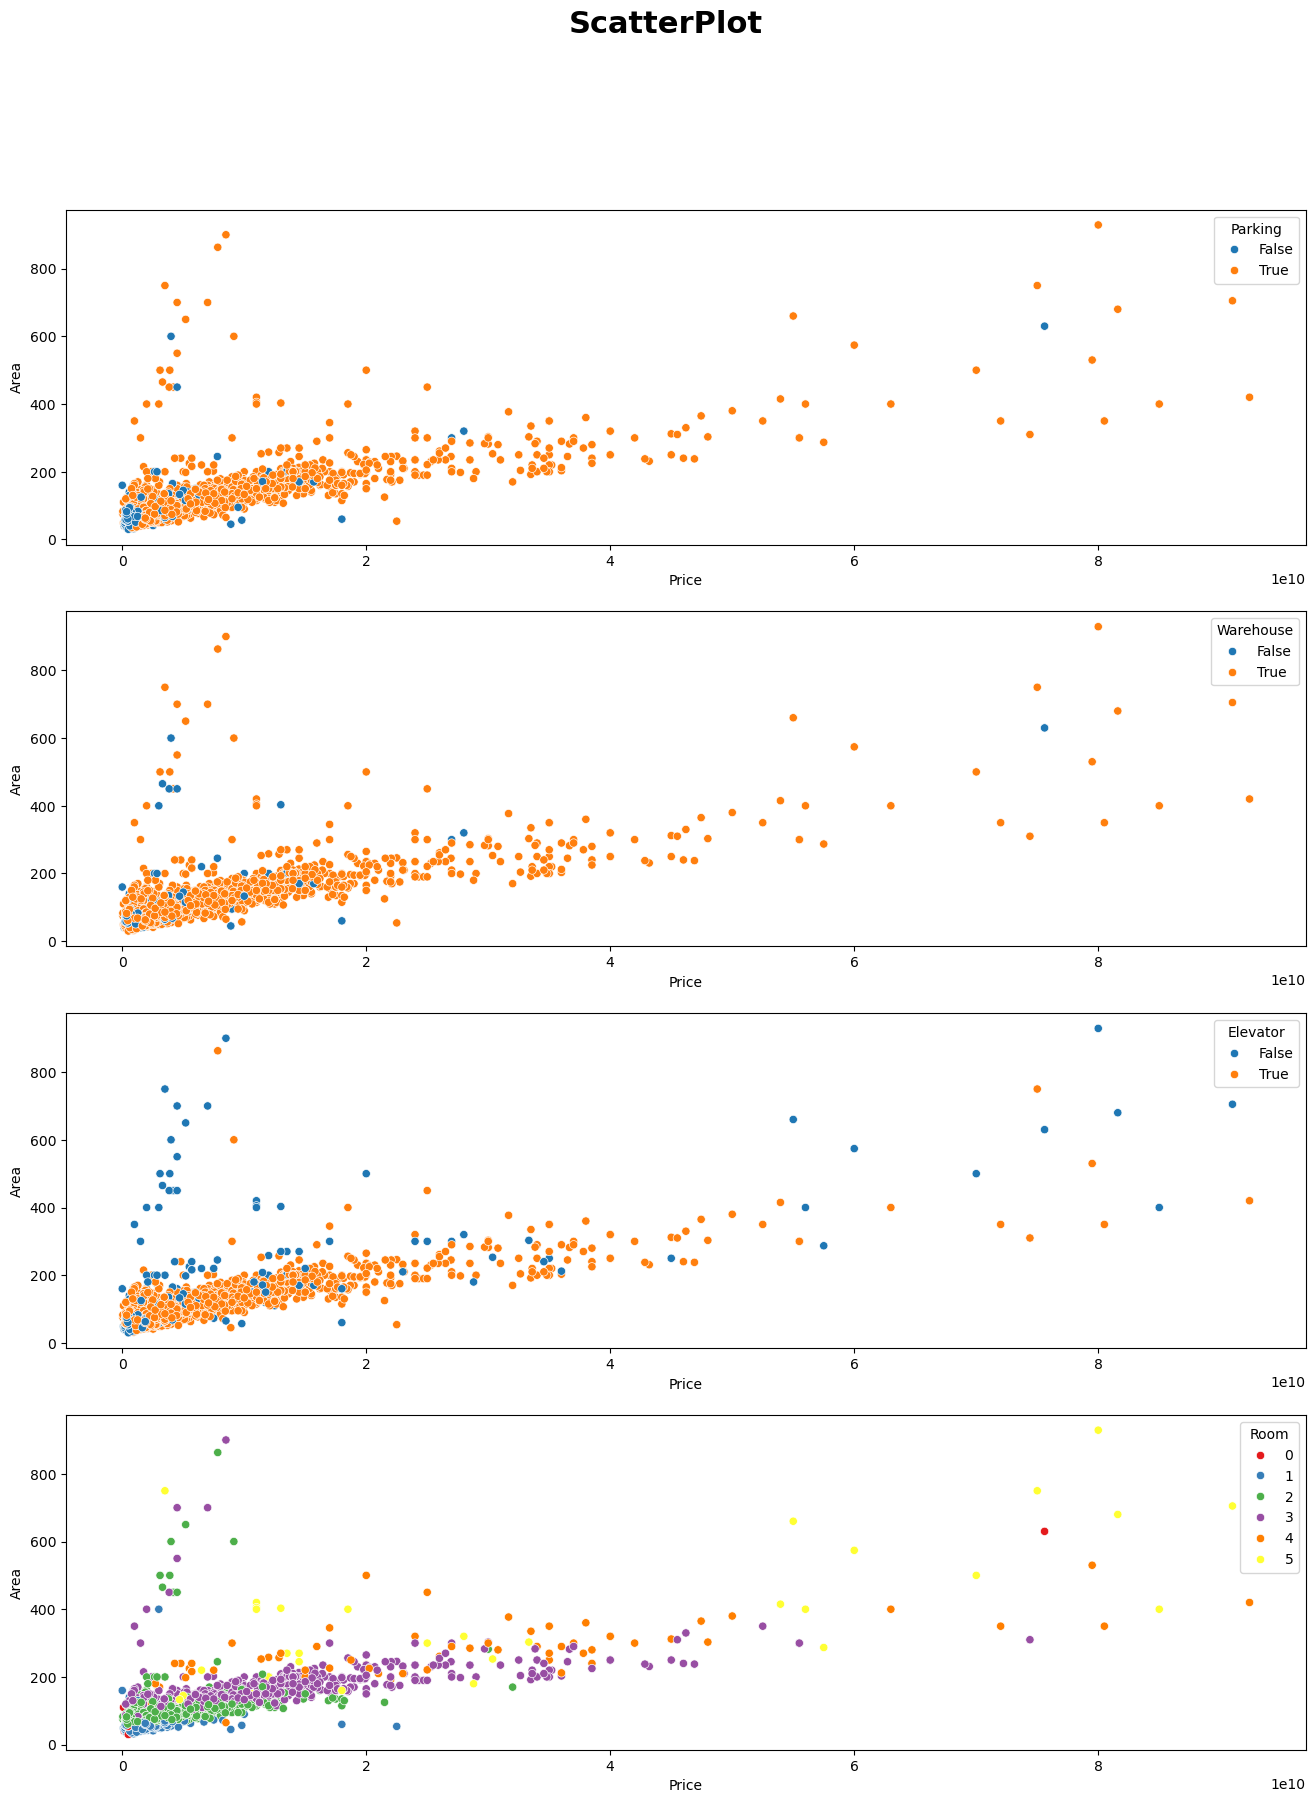

In [273]:
plt.figure(figsize=(16,20))
plt.suptitle("ScatterPlot", fontweight="bold", fontsize=22)
axes=[]

axes.append(plt.subplot(4,1,1))
sns.scatterplot(x='Price',y='Area', hue='Parking', data=df)

axes.append(plt.subplot(4,1,2))
sns.scatterplot(x='Price',y='Area', hue='Warehouse', data=df)

axes.append(plt.subplot(4,1,3))
sns.scatterplot(x='Price',y='Area', hue='Elevator', data=df)

axes.append(plt.subplot(4,1,4))
sns.scatterplot(x='Price', y='Area', hue="Room", data=df, palette="Set1")
plt.show()

# Correlation Heatmap

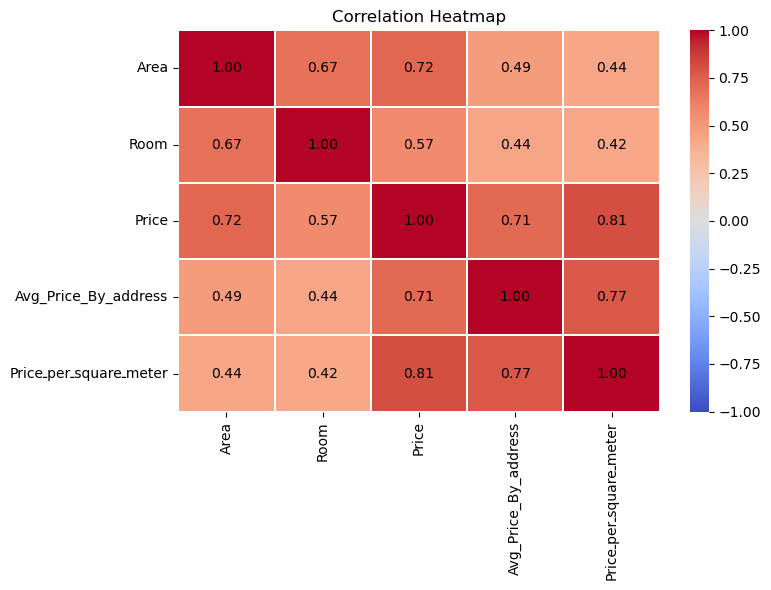

In [274]:
 
numerical_columns=df[df.select_dtypes(include=['int64', 'float64']).columns]

if numerical_columns.shape[1] >= 2:
    plt.figure(figsize=(8,6))
    corr = numerical_columns.corr()
    sns.heatmap(corr, cmap='coolwarm', fmt='.2f',annot_kws={'color': 'black'}, vmin=-1, vmax=1, linewidths=0.2, annot=True)
    plt.title('Correlation Heatmap')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric columns for a correlation heatmap.')

 # ML 

In [275]:
#Lable Encoding

cols_to_encode = ['Parking', 'Warehouse', 'Elevator', 'Address']

for col in cols_to_encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
df.sample(5)

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Avg_Price_By_address,Priceـperـsquareـmeter
191,114.0,2,1,1,1,184,3.820000e+09,4.376364e+09,3.350877e+07
2603,57.0,2,0,0,0,141,1.090000e+09,1.397009e+09,1.912281e+07
3124,71.0,2,1,1,1,40,2.950000e+09,3.854716e+09,4.154930e+07
1690,90.0,2,1,1,1,163,3.280000e+09,3.178452e+09,3.644444e+07
799,85.0,2,1,1,1,115,1.150000e+09,5.235906e+08,1.352941e+07


In [276]:
#Standardize numerical features (StandardScaler)
scaler=StandardScaler()
x=df[['Priceـperـsquareـmeter','Area','Warehouse','Elevator','Parking','Room','Address']]
y=df[['Price']]
x_scaled=scaler.fit_transform(x)

x_scaled

array([[-0.37623246, -0.63153331,  0.30464673, ...,  0.42413507,
        -1.42237999,  1.01365174],
       [-0.32984759, -0.67467339,  0.30464673, ...,  0.42413507,
        -1.42237999,  1.01365174],
       [-1.08398662, -0.40145286,  0.30464673, ...,  0.42413507,
        -0.10677383,  0.23852391],
       ...,
       [-1.1501829 , -0.45897297, -3.28249052, ..., -2.35773946,
        -0.10677383,  0.19877377],
       [ 0.38096928, -0.02757214,  0.30464673, ...,  0.42413507,
        -0.10677383, -1.31173174],
       [-1.16523398, -0.35831278,  0.30464673, ..., -2.35773946,
        -0.10677383,  0.19877377]])

# Spilit Data to Train & Test 

In [277]:
x_train,x_test,y_train,y_test=train_test_split(x_scaled,y,test_size=0.2 , random_state=42 )
print(x_train.shape)
print(x_test.shape)

(2760, 7)
(690, 7)


r2score : 0.8509928029567333


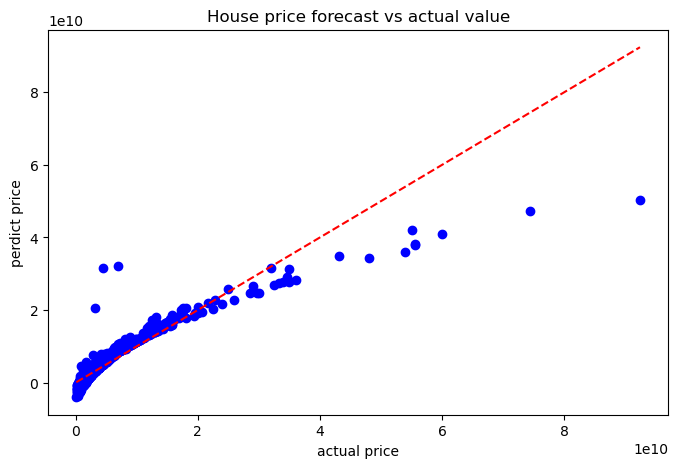

In [278]:
#LinearRegression
model_Linear_reg = LinearRegression()

model_Linear_reg.fit(x_train, y_train)
y_pred = model_Linear_reg.predict(x_test)
r2=r2_score(y_test,y_pred)
print('r2score :', r2 )

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('House price forecast vs actual value')
plt.xlabel('actual price')
plt.ylabel('perdict price')
plt.show()

In [279]:
#Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100,random_state=42)
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)
print("R2 Score Of Random Forest:", r2_score(y_test, y_pred))

d:\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


R2 Score Of Random Forest: 0.9749161851321873


In [280]:
#GradiantBoosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100,random_state=42)
gb_model.fit(x_train, y_train)
y_pred = gb_model.predict(x_test)
print("R2 Score Of GradiantBoosting :", r2_score(y_test, y_pred))

d:\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


R2 Score Of GradiantBoosting : 0.9877173207607323


In [281]:
#Cross Validation
cv_scores = cross_val_score(gb_model, x_train, y_train.values.ravel(), cv=5, scoring='r2')
print("Cross Validation R2 scores:",cv_scores)
print("Average R2:", cv_scores.mean())
print("Std R2:", cv_scores.std())

Cross Validation R2 scores: [0.94899425 0.99043059 0.98875    0.97544935 0.98830353]
Average R2: 0.9783855440547393
Std R2: 0.015641871011190574


In [282]:
#XGBOOST
xgb_model = XGBRegressor(n_estimators=300,learning_rate=0.05,max_depth=3,subsample=0.8,colsample_bytree=0.8,reg_lambda=1.0,reg_alpha=0.1,random_state=42,n_jobs=-1)
xgb_model.fit(x_train, y_train.values.ravel())
y_pred = xgb_model.predict(x_test)
y_train_pred = xgb_model.predict(x_train)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred)
print(f"Train R²: {r2_train:.4f} | Test R²: {r2_test:.4f}")
print(" Final XGBoost Model Performance: " , r2_score(y_test, y_pred))

Train R²: 0.9964 | Test R²: 0.9802
 Final XGBoost Model Performance:  0.9801684021949768


It has only a 1.2% accuracy loss on the test data 
 meaning it has almost No significant overfitting.

In [283]:
models = {
    "Linear Regression": model_Linear_reg,
    "Random Forest": rf_model,
    "Gradient Boosting": gb_model,
    "XGB Regressor": xgb_model
}

for name, m in models.items():
    print(f"{name} - Train R²: {m.score(x_train, y_train):.4f} | Test R²: {m.score(x_test, y_test):.4f}")

Linear Regression - Train R²: 0.8295 | Test R²: 0.8510
Random Forest - Train R²: 0.9958 | Test R²: 0.9749
Gradient Boosting - Train R²: 0.9979 | Test R²: 0.9877
XGB Regressor - Train R²: 0.9964 | Test R²: 0.9802


In [284]:
import joblib
joblib.dump(xgb_model, "house_price_xgb_final.joblib")
joblib.dump(scaler, "scaler.joblib")
print(" Final XGBoost model and scaler saved successfully!")

 Final XGBoost model and scaler saved successfully!


In [285]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import joblib

df = pd.read_csv("housePrice.csv")
le = LabelEncoder()
le.fit(df["Address"])

joblib.dump(le, "address_encoder.joblib")
print(" Address encoder saved successfully!")


 Address encoder saved successfully!
